# Data cleaning

### Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import
data = pd.read_csv('dataset_mood_smartphone.csv')

#Convert time column to date time format
data['time']= pd.to_datetime(data['time']) 

### Changing to multi index with time and ID

In [2]:
data = data.set_index(['id', 'time'])

We want to reformat the data such that we have a number of observations for each patient, with each observation consisting of some time period e.g one week. Each observation will have a measurement for each attribute (e.g., Avg time spent on weather app over period) with the dependent variable as the average mood over the period. 

In [3]:
#reshaping the dataframe so that each column is a feature, indexed first by patient then time
data2 = pd.pivot_table(data, index=['id', 'time'], columns='variable', values='value')

### Aggregating the data into time windows 

For all of the apps, sms and calls we take the sum over the windows, since they are either times spent or number of calls etc. For arousal, mood and valence we take the mean.

In [4]:
#This is currently grouping observations into 2 day windows, can make a decision on this later

data2 = data2.astype(float)
data2 = data2.groupby([pd.Grouper(freq='2D', level='time'), 
                             pd.Grouper(level='id')]).agg({'activity': 'sum', 'appCat.builtin':'sum',
                                                           'appCat.communication':'sum', 'appCat.entertainment':'sum',
                                                           'appCat.finance':'sum', 'appCat.game':'sum', 'appCat.office':'sum',
                                                           'appCat.other':'sum', 'appCat.social':'sum', 'appCat.travel':'sum',
                                                           'appCat.unknown':'sum', 'appCat.utilities':'sum', 'appCat.weather':'sum',
                                                           'call':'sum', 'screen':'sum', 'sms':'sum','circumplex.valence':'mean',
                                                           'circumplex.arousal':'mean', 'mood':'mean'})

### Removing observations/days without mood measurements

In [5]:
data2 = data2.dropna(subset=['mood'])

### Dropping columns with little data

In [6]:
data2 = data2.drop(columns=['appCat.finance','appCat.game', 'appCat.unknown', 'appCat.weather'])

### Remove outliers

It is clear from the plots that there are some outliers that are nonsensical. No values should be negative apart from those for arousal or valence, which have a minimum value of -2. Therefore a good starting point is to remove any values which are less than that for the whole dataframe.

In [7]:
from scipy import stats

data2 = data2.astype(float)
data2 = data2[(np.abs(stats.zscore(data2)) < 4).all(axis=1)]
data2

activity  appCat.builtin  appCat.communication  \
time       id                                                         
2014-02-25 AS14.01   0.000000           0.000                 0.000   
2014-02-27 AS14.01   0.000000           0.000                 0.000   
2014-03-03 AS14.17   0.000000           0.000                 0.000   
2014-03-05 AS14.17   0.000000           0.000                 0.000   
2014-03-07 AS14.08   0.000000           0.000                 0.000   
           AS14.17   0.000000           0.000                 0.000   
2014-03-09 AS14.08   0.000000           0.000                 0.000   
           AS14.17   0.000000           0.000                 0.000   
2014-03-11 AS14.08   0.000000           0.000                 0.000   
           AS14.17   0.000000           0.000                 0.000   
2014-03-13 AS14.05   0.000000         257.071              4362.429   
           AS14.15   0.000000         269.401                35.161   
           AS14.16   0.000000          59.103               191.282   
           AS14.17   0.000000           0.000                 0.000   
2014-03-15 AS14.02   0.000000        4858.155              5350.532   
           AS14.05   0.000000        1187.582             10554.952   
           AS14.08   0.000000         217.686              2135.666   
           AS14.12   0.000000           0.000                 0.000   
           AS14.15   0.000000          40.433               124.345   
           AS14.16   0.000000         317.672               253.745   
2014-03-17 AS14.02   6.444104        3833.868              8451.197   
           AS14.05   3.437211        1262.371              6185.550   
           AS14.08   0.717126          62.504              6479.912   
           AS14.13   0.000000        1583.580              6897.372   
           AS14.15   1.306109        1355.699              1780.747   
           AS14.16   1.105448         237.478               899.181   
2014-03-19 AS14.02  13.311761        3332.535              4751.360   
           AS14.05   6.051554         358.015              8807.604   
           AS14.07   0.000000        3298.259             13372.661   
           AS14.08   2.892985        4912.718              1291.150   
...                       ...             ...                   ...   
2014-05-14 AS14.29   0.250000           0.000               204.865   
           AS14.31   0.000000           0.000                 0.000   
           AS14.33   2.419762        3549.533              3634.315   
2014-05-16 AS14.24   1.244735        3028.985              5169.967   
           AS14.26   5.772319        3930.317              6224.585   
           AS14.33   1.642918        3230.606               969.627   
2014-05-18 AS14.24   0.833333        1870.086              5920.312   
           AS14.26   3.309404        1738.779              3658.915   
           AS14.33   0.645100        2993.325              2426.786   
2014-05-20 AS14.24   2.293213        1992.499              2673.763   
           AS14.26   5.933059        2113.152              3613.468   
           AS14.33   0.798367        1148.998              2682.403   
2014-05-22 AS14.24   1.280787        1733.681              3549.557   
           AS14.26   5.940248        4988.745              4441.740   
           AS14.33   0.695204        1730.416              2091.773   
2014-05-24 AS14.24   1.377850        1552.609              1630.288   
           AS14.26   6.439412        4887.187              5257.566   
           AS14.33   4.056681        3635.586              3831.256   
2014-05-26 AS14.24   1.611237        1738.054              2998.893   
           AS14.26   1.962950        5082.516              5076.263   
           AS14.33   1.802521        1775.130              3313.940   
2014-05-28 AS14.24   2.803083        4098.199              5203.125   
           AS14.26   2.046037        8278.606              3442.583   
           AS14.33   6.543735        2951.080

### Instead aggregating data into windows up to each mood measurement 

In [ ]:
#This will give us more observations that grouping by day

data2 = data2.groupby([pd.Grouper(freq='1D', level='time'), 
                             pd.Grouper(level='id')]).agg({'activity': 'sum', 'appCat.builtin':'sum',
                                                           'appCat.communication':'sum', 'appCat.entertainment':'sum',
                                                           'appCat.finance':'sum', 'appCat.game':'sum', 'appCat.office':'sum',
                                                           'appCat.other':'sum', 'appCat.social':'sum', 'appCat.travel':'sum',
                                                           'appCat.unknown':'sum', 'appCat.utilities':'sum', 'appCat.weather':'sum',
                                                           'call':'sum', 'screen':'sum', 'sms':'sum','circumplex.valence':'mean',
                                                           'circumplex.arousal':'mean', 'mood':'mean'})

# Exploration

### Mood distribution 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019451DEEFD0>]],
      dtype=object)

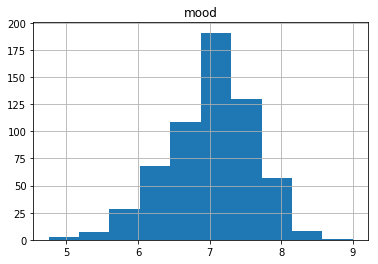

In [8]:
#We can now look at the distributions for each variable
data2.hist('mood')

### Observation counts for each day

In [9]:
#This tells us the number of individuals for which we have mood data for each day in the dataset
data2.groupby(level=0)['mood'].count()

time
2014-02-25     1
2014-02-27     1
2014-03-03     1
2014-03-05     1
2014-03-07     2
2014-03-09     2
2014-03-11     2
2014-03-13     4
2014-03-15     6
2014-03-17     6
2014-03-19     9
2014-03-21    14
2014-03-23    14
2014-03-25    16
2014-03-27    17
2014-03-29    18
2014-03-31    20
2014-04-02    23
2014-04-04    24
2014-04-06    24
2014-04-08    21
2014-04-10    24
2014-04-12    23
2014-04-14    23
2014-04-16    24
2014-04-18    23
2014-04-20    24
2014-04-22    26
2014-04-24    22
2014-04-26    26
2014-04-28    24
2014-04-30    24
2014-05-02    21
2014-05-04    23
2014-05-06    12
2014-05-08    10
2014-05-10     7
2014-05-12     7
2014-05-14     6
2014-05-16     3
2014-05-18     3
2014-05-20     3
2014-05-22     3
2014-05-24     3
2014-05-26     3
2014-05-28     3
2014-05-30     3
2014-06-01     1
2014-06-03     1
2014-06-07     1
Freq: 2D, Name: mood, dtype: int64

It is clear that there is a narrow time period over which we have data for all patients simulatneously. We cannot do much with days for which we little or no mood data, therefore we could consider discarding data in the early and late periods.

### Observation counts for each patient 

In [10]:
#This tells us the number of mood observations for each individual
data2.groupby(level=1)['mood'].count()

id
AS14.01    23
AS14.02    20
AS14.03    23
AS14.05    26
AS14.06    24
AS14.07    22
AS14.08    26
AS14.09    21
AS14.12    19
AS14.13    23
AS14.14    18
AS14.15    28
AS14.16    25
AS14.17    27
AS14.19    22
AS14.20    24
AS14.23    18
AS14.24    27
AS14.25    14
AS14.26    34
AS14.27    20
AS14.28    16
AS14.29    19
AS14.30    23
AS14.31    18
AS14.32    22
AS14.33    20
Name: mood, dtype: int64

### Counts for each variable, for each patient

In [12]:
#Number of available instances for each variable, for each patient
data2.groupby(level=1).count()

,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.utilities,call,screen,sms,circumplex.valence,circumplex.arousal,mood
id,,,,,,,,,,,,,,,
AS14.01,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
AS14.02,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
AS14.03,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
AS14.05,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
AS14.06,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
AS14.07,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
AS14.08,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
AS14.09,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
AS14.12,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19


There are a number of attributes for which we have few or no measurements for many of the patients, namely: Finance, Games, office, unknown, and weather. In some of these cases they may be entirely useless, especially if they happen to be highly correlated with other variables. We could consider taking binary indicators for some of these, with the intuition that if they check finance or office apps they have assets or a job, if they check the weather app they go outside, if they play mobile games they procrastinate etc

### Pairwise plots

Looking at the number of non-zero observations in each column after the above transformations

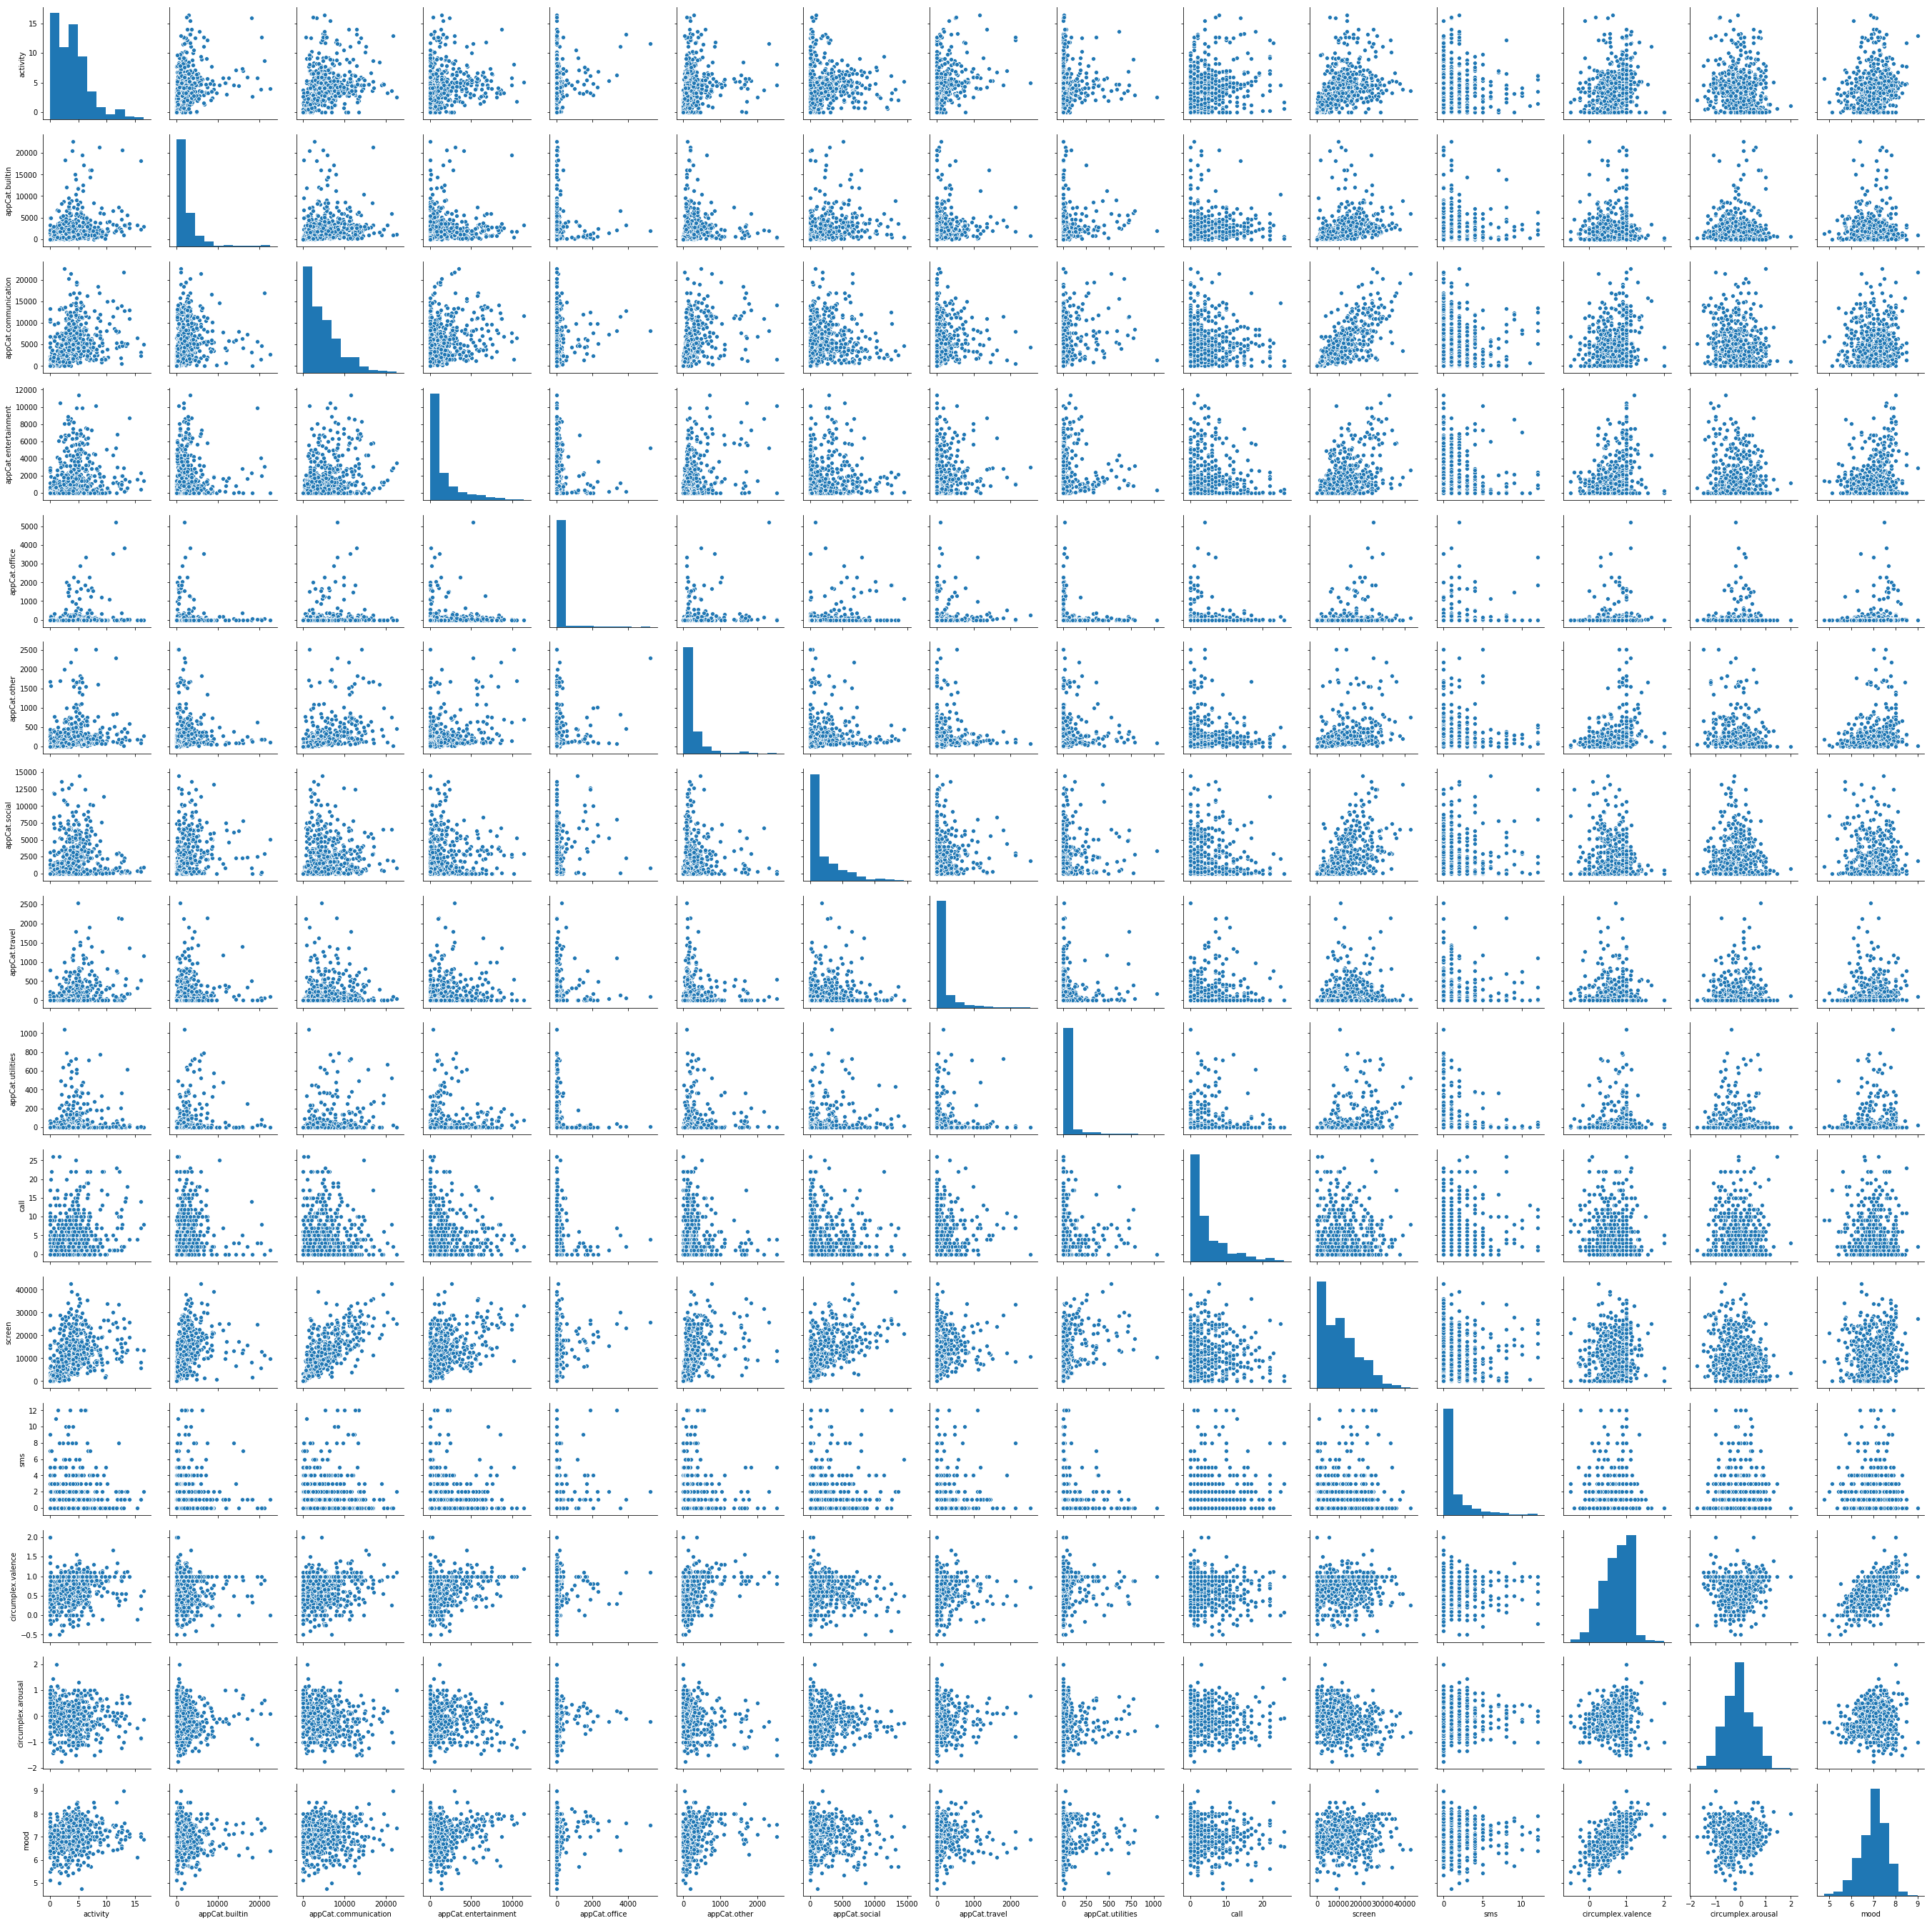

In [13]:
import seaborn as sns

sns.pairplot(data2.loc[:,data2.dtypes == 'float64'])

### Correlation between predictors

In [ ]:
corr_matrix = data2.corr()
corr_matrix['mood']

# Feature engineering

Here we need to create new variables to improve our predictive power

Ideas so far:
- Days of week, month of recording
- Mood swing in last week
- Mornging/evening
- Binary indicators for some ommitted apps

In the paper on this dataset they say that basically none of the apps have any predictive power - once we show this 
#ourselves we could simplify the model down immensely using principle components/ indicators for 
"uses phone a lot-or not" 

# OLS as first test of feature importance

In [ ]:
olsdata = data2.groupby([pd.Grouper(freq='6M', level='time'), 
                             pd.Grouper(level='id')]).agg({'activity': 'sum', 'appCat.builtin':'sum',
                                                           'appCat.communication':'sum', 'appCat.entertainment':'sum',
                                                           'appCat.finance':'sum', 'appCat.game':'sum', 'appCat.office':'sum',
                                                           'appCat.other':'sum', 'appCat.social':'sum', 'appCat.travel':'sum',
                                                           'appCat.unknown':'sum', 'appCat.utilities':'sum', 'appCat.weather':'sum',
                                                           'call':'sum', 'screen':'sum', 'sms':'sum','circumplex.valence':'mean',
                                                           'circumplex.arousal':'mean', 'mood':'mean'})
olsdata.head()

# Principle component Analysis

It's very probable that many of the apps serve similar purposes for the user and therefore may have a similar effect - a PCA could possibly decompose these features into a smaller subset representing e.g. A need for socializing (Messneger apps), boredom (News, finance)

In [ ]:
from sklearn.preprocessing import StandardScaler

#Before we can run PCA we need to standarize all of the features

features = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 
            'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 
            'appCat.weather', 'call', 'screen', 'sms', 'circumplex.valence', 'circumplex.arousal']
x = data2.loc[:, features].values
x = StandardScaler().fit_transform(x)

y = data2.loc[:,['mood']].values

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf.head()

In [ ]:
finalDf = pd.concat([principalDf, data2[['mood']]], axis = 1)

# Mean model

# Linear regression for aggregated data

# Decision Tree/Random forrest

# Individual models (ARIMA?)